In [11]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from process import compress_video

import tensorflow as tf
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense

%matplotlib inline

## Label Load 및 추출 함수

In [12]:
import numpy as np

def quadrant_diff(arr, highlight_map):
    """
    Calculate differences within each quadrant of the frame and update highlight_map based on these differences, 
    using the standard deviation of all differences as the threshold.

    Args:
    arr (List of np.array): Each element is a 9x256x256x1 numpy array representing a frame.

    Returns:
    List: Updated highlight_map indicating highlights based on quadrant differences.
    """
    all_diffs = []
    
    for i in range(len(arr) - 1):
        for quadrant in range(4):
            # 4개로 분리된 frame의 차이를 계산하는 부분
            quarter_shape = (arr[i].shape[1] // 2, arr[i].shape[2] // 2)
            x_start = (quadrant % 2) * quarter_shape[0]
            y_start = (quadrant // 2) * quarter_shape[1]
            current_quarter = arr[i][:, x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]
            next_quarter = arr[i + 1][:, x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]

            # 각 frame의 차이를 계산
            diff = np.abs(current_quarter - next_quarter).sum()
            all_diffs.append(diff)
    
    # 계산된 frame 차이의 표준편차를 임계값으로 설정
    threshold = np.std(all_diffs)
    
    # 해당 임계값을 바탕으로 frame 라벨 update
    for i in range(len(arr) - 1):
        count_above_threshold = 0
        for quadrant in range(4):
            quarter_shape = (arr[i].shape[1] // 2, arr[i].shape[2] // 2)
            x_start = (quadrant % 2) * quarter_shape[0]
            y_start = (quadrant // 2) * quarter_shape[1]
            current_quarter = arr[i][:, x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]
            next_quarter = arr[i + 1][:, x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]
            
            diff = np.abs(current_quarter - next_quarter).sum()

            if diff > threshold:
                count_above_threshold += 1
        
        if count_above_threshold >= 1:
            highlight_map[i] += 1
        else:
            highlight_map[i] = 0

    return highlight_map


In [13]:
# Load JSON data
with open('test.json', 'r') as file:
    json_data = json.load(file)

def parse_annotations(annotation:list, block_num:int):
    """
    Extracts Every Annotation from json label file
    
    Args:
    annotations(List): List of Dictionary for annotations label with highlight and represent

    Returns:
    List: Whether each block is Highlight or not
    """
    global video_path
    highlight_map = {}

    video_path = annotation["video_path"]
    annotations = annotation["annots"]
    
    for annot in annotations:
        highlights = annot['highlight']

        for num in highlights:
            highlight_map[num] = 1
            
    ret = [0 for _ in range(block_num)]
    
    for key in highlight_map.keys():
        try:
            ret[key] = 1
        except:
            ret.append(1)

    video_frames = np.load(video_path)
    ret = quadrant_diff(video_frames, ret)
                
    return video_frames, ret

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


## Model - Video

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense

from tensorflow.keras.layers import Dropout, BatchNormalization

def create_cnn_lstm_model():
    inputs = Input(shape=(9, 256, 256, 1))

    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)

    x = LSTM(100, return_sequences=False)(x)
    x = Dropout(0.5)(x)

    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

with tf.device('/GPU:0'):
    model = create_cnn_lstm_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 9, 256, 256, 1)]  0         
                                                                 
 time_distributed_30 (TimeDi  (None, 9, 254, 254, 32)  320       
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 9, 127, 127, 32)  0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 9, 127, 127, 32)  128       
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 9, 125, 125, 64)  18496     
 stributed)                                                

## Model Trainer 함수

In [50]:
def trainer(model):
    json_path = 'processed/label/processed_video_data.json'
    model_path = './video_model_base_256.h5'

    if os.path.exists(model_path):
        model = load_model(model_path)
        print("Loaded existing model.")
    else:
        print("No existing model found, starting training new model.")

    with open(json_path, 'r') as file:
        json_data = json.load(file)

    train_length = int(len(json_data) * 0.7)
    train_data = json_data[:train_length]
    test_data = json_data[train_length:]
    all_histories = []

    # Training phase
    for json_dict in tqdm(train_data):
        video, label = parse_annotations(json_dict, json_dict['three_secs'][-1])
        
        X = video
        y = np.array(label)

        min_length = min(len(X), len(y))
        X, y = X[:min_length], y[:min_length]

        y = to_categorical(y, num_classes=3)
        
        with tf.device('/GPU:0'):
            history = model.fit(X, y, epochs=5, verbose=0, batch_size=8)
        
        all_histories.append(history.history)
    
    model.save(model_path)

    # Test phase
    for i, json_dict in enumerate(test_data):
        video, label = parse_annotations(json_dict, json_dict['three_secs'][-1] + 1)
        
        X = video
        y = np.array(label)

        min_length = min(len(X), len(y))
        X, y = X[:min_length], y[:min_length]

        y = to_categorical(y, num_classes=3)
        
        print(f"Test {i} :: {model.evaluate(X, y)}")

    return model, all_histories

In [51]:
def plot_training_history(histories):
    epochs = range(1, len(histories[0]['loss']) + 1)
    all_loss = [h['loss'] for h in histories]
    all_acc = [h['accuracy'] for h in histories]

    plt.figure(figsize=(20, 15))
    plt.subplot(1, 2, 1)
    for i, loss in enumerate(all_loss):
        plt.plot(epochs, loss, label=f'Training {i+1}')
    plt.title('Loss over training videos')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2)
    for i, acc in enumerate(all_acc):
        plt.plot(epochs, acc, label=f'Training {i+1}')
    plt.title('Accuracy over training videos')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [52]:
model_traied, history = trainer(model)

No existing model found, starting training new model.


  0%|          | 0/69 [05:02<?, ?it/s]


KeyboardInterrupt: 

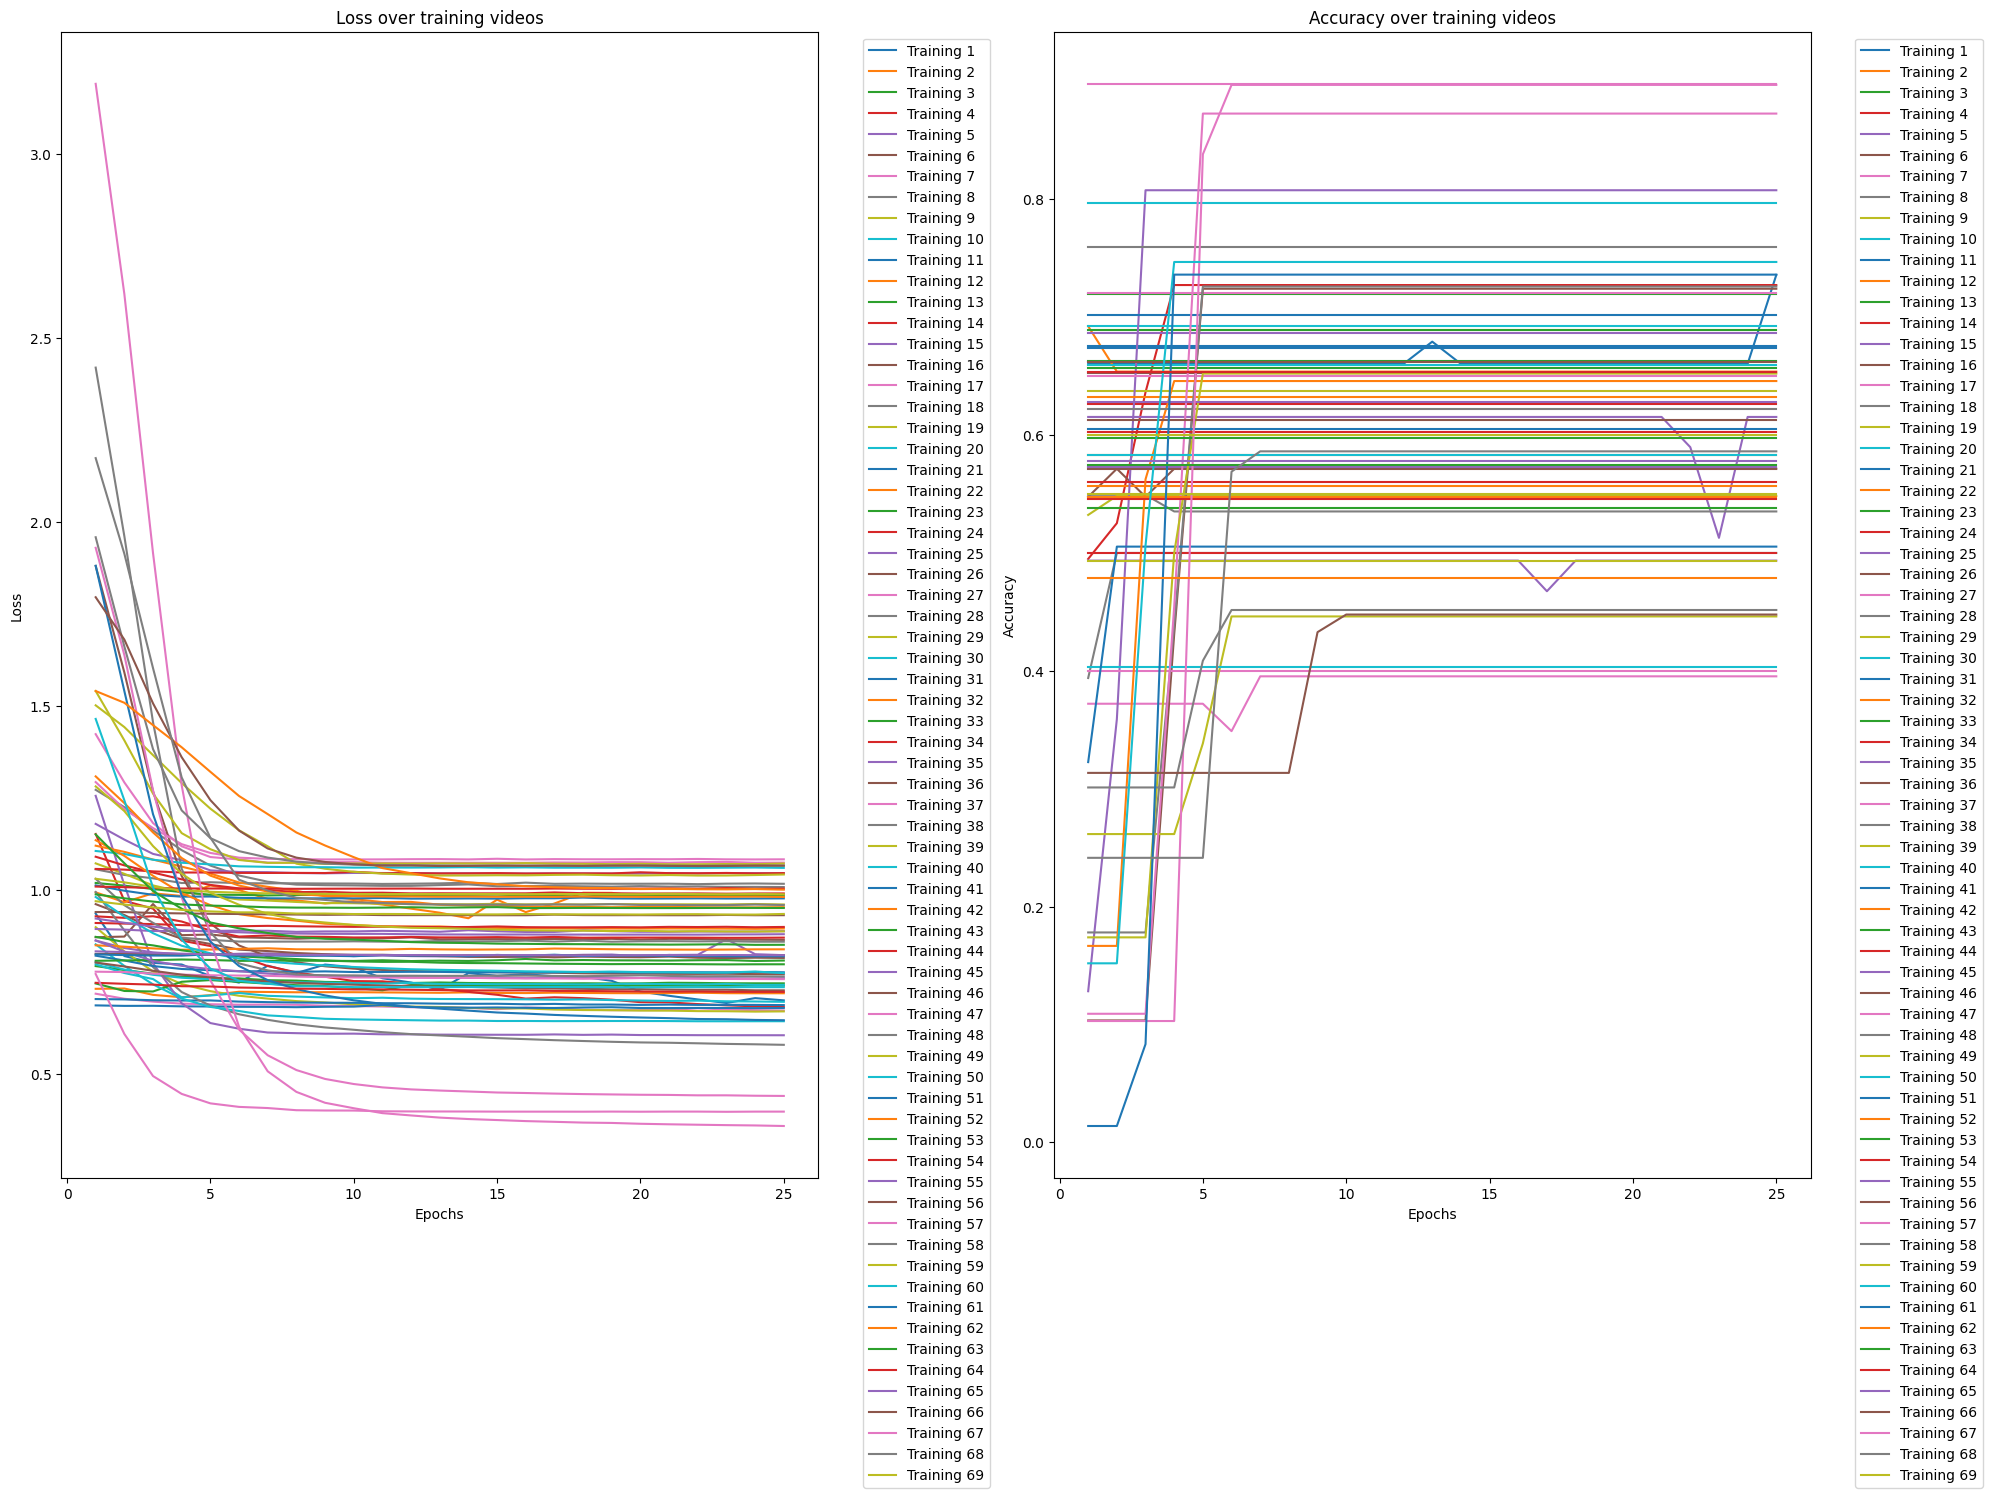

In [46]:
plot_training_history(history)

## Train Audio model

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_simple_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(130, 130, 1)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import ResNet50

def create_resnet50_model():
    input_layer = tf.keras.Input(shape=(130, 130, 1))
    
    x = tf.tile(input_layer, [1, 1, 1, 3])

    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)
    base_model.trainable = False 

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax') 
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [43]:
model_audio_resnet = create_resnet50_model()
model_audio_resnet.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               6553728   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
Total params: 30,141,827
Trainable params: 6,554,115
Non-trainable params: 23,587,712
___________________________________

In [30]:
model_audio = create_simple_cnn()
model_audio.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 128)     

In [31]:
import numpy as np

def quadrant_diff(arr, highlight_map):
    all_diffs = []
    
    for i in range(len(arr) - 1):
        current_frame = arr[i]
        next_frame = arr[i + 1]
        if current_frame.ndim == 2: 
            current_frame = current_frame[..., np.newaxis]
            next_frame = next_frame[..., np.newaxis]

        for quadrant in range(4):
            quarter_shape = (current_frame.shape[0] // 2, current_frame.shape[1] // 2)
            x_start = (quadrant % 2) * quarter_shape[0]
            y_start = (quadrant // 2) * quarter_shape[1]
            current_quarter = current_frame[x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]
            next_quarter = next_frame[x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]
            
            diff = np.abs(current_quarter - next_quarter).sum()
            all_diffs.append(diff)
    
    threshold = np.std(all_diffs)
    
    for i in range(len(arr) - 1):
        count_above_threshold = 0
        current_frame = arr[i]
        next_frame = arr[i + 1]
        if current_frame.ndim == 2:
            current_frame = current_frame[..., np.newaxis]
            next_frame = next_frame[..., np.newaxis]

        for quadrant in range(4):
            quarter_shape = (current_frame.shape[0] // 2, current_frame.shape[1] // 2)
            x_start = (quadrant % 2) * quarter_shape[0]
            y_start = (quadrant // 2) * quarter_shape[1]
            current_quarter = current_frame[x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]
            next_quarter = next_frame[x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]
            
            diff = np.abs(current_quarter - next_quarter).sum()
            if diff > threshold:
                count_above_threshold += 1
        
        if count_above_threshold == 4:
            highlight_map[i] += 1
        elif count_above_threshold >= 1:
            highlight_map[i] = 2
        else:
            highlight_map[i] = 0

    return highlight_map


In [32]:
# Load JSON data
with open('test.json', 'r') as file:
    json_data = json.load(file)

def parse_annotations(annotation:list, block_num:int):
    """
    Extracts Every Annotation from json label file
    
    Args:
    annotations(List): List of Dictionary for annotations label with highlight and represent

    Returns:
    List: Whether each block is Highlight or not
    """
    global video_path
    highlight_map = {}

    video_path = annotation["audio_path"]
    annotations = annotation["annots"]
    
    for annot in annotations:
        highlights = annot['highlight']

        for num in highlights:
            highlight_map[num] = 1
            
    ret = [0 for _ in range(block_num)]
    
    for key in highlight_map.keys():
        try:
            ret[key] = 1
        except:
            ret.append(1)

    video_frames = np.load(video_path)
    ret = quadrant_diff(video_frames, ret)
                
    return video_frames, ret

In [35]:
def trainer(model):
    # data_list = os.listdir("processed/video") # 동영상 데이터 
    json_path = 'processed\label\processed_video_data.json'
    model_path = './audio_model.h5'

    if os.path.exists(model_path):
        model = load_model(model_path)
        print("Loaded existing model.")
    else:
        print("No existing model found, starting training new model.")

    with open(json_path, 'r') as file:
        json_data = json.load(file)

    train_length = int(len(json_data) * 0.7)
    
    train_data = json_data[:train_length]
    test_data = json_data[train_length:]
    all_histories = []

    ## 학습 부분
    for json_dict in tqdm(train_data):
        video, label = parse_annotations(json_dict, json_dict['three_secs'][-1])
        
        X = video # i번 영상의 npy 파일
        y = np.array(label) # 1번 영상에 대한 각 블럭의 하이라이트 여부

        min_length = min(len(X), len(y))
        X, y = X[:min_length], y[:min_length]

        y = to_categorical(y, num_classes=3)
        
        history = model.fit(X, y, 
                            epochs=10, 
                            verbose=0, 
                            batch_size=32)
        
        all_histories.append(history.history) 
        model.save('./audio_model.h5')

    return model, all_histories

In [37]:
audio_model, audio_hist = trainer(model_audio)

Loaded existing model.


100%|██████████| 69/69 [00:22<00:00,  3.04it/s]


In [44]:
audio_model, audio_hist = trainer(model_audio_resnet)

Loaded existing model.


100%|██████████| 69/69 [00:21<00:00,  3.14it/s]


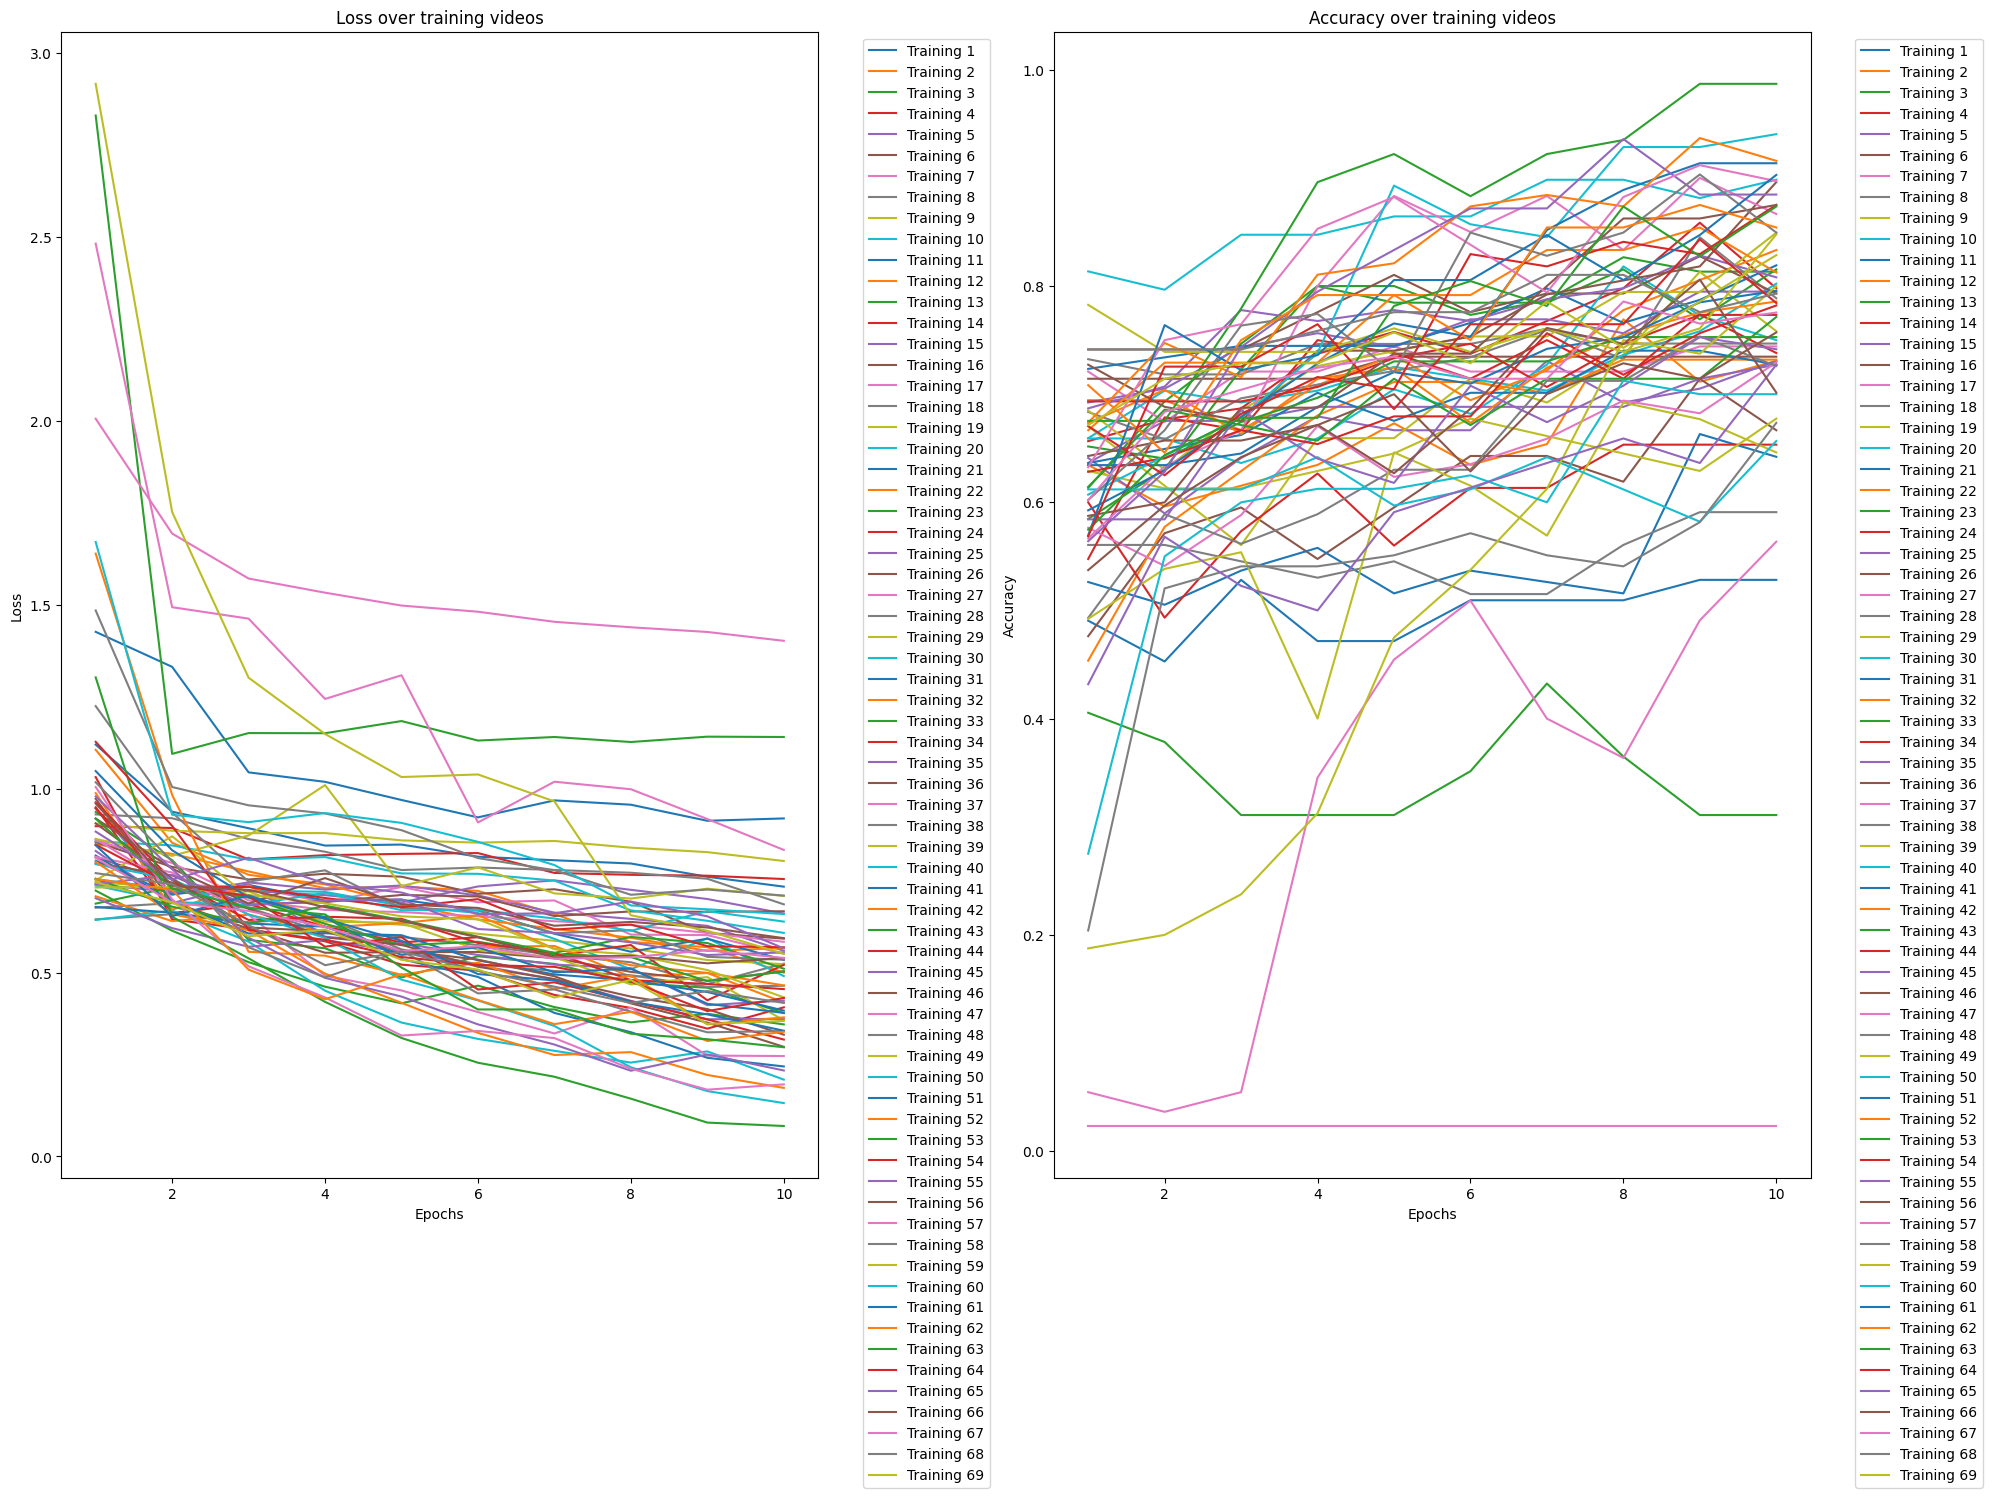

In [45]:
plot_training_history(audio_hist)

In [1]:
label = "0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1"

In [10]:
def find_start_points(array):
    start_points = []
    for i, value in enumerate(array):
        if value == 1:
            seconds = i * 3
            minutes = seconds // 60
            seconds = seconds % 60
            start_points.append((minutes, seconds))
    return start_points

def save_to_file(start_points, filename="start_points.txt"):
    with open(filename, "w") as file:
        for minutes, seconds in start_points:
            file.write(f"{minutes}분 {seconds}초\n")

# 주어진 문자열을 배열로 변환
input_string = "0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1"
array = list(map(int, input_string.split()))

# 각 블럭의 시작 점 찾기
start_points = find_start_points(array)

# 파일로 저장
save_to_file(start_points)

print("시작 점이 파일로 저장되었습니다.")


시작 점이 파일로 저장되었습니다.
